## Sketch RNN

Lets implement Sketch RNN from https://arxiv.org/pdf/1704.03477.pdf!

### Data
First get the data (npz files), I stored it locally. https://github.com/googlecreativelab/quickdraw-dataset

In [25]:
import os
import numpy as np
from utils_from_sketchRNN import *
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
data_file_dir = '/Users/phumphreys/Repositories/quick_draw_files'
files = os.listdir(data_file_dir)
categories = [file.split('.')[0] for file in files if '.npz' in file]

category = categories[1]
print('Lets play with the category: {0}'.format(category))
data = np.load(os.path.join(data_file_dir,category+'.npz'),encoding='bytes')

train = data['train']
test = data['test']
valid = data['valid']

Lets play with the category: book
total images <= max_seq_len is 70000


In [214]:
x=[]
y=[]
for t in train:
    x.extend(t[:,0])
    y.extend(t[:,0])
std_dev = 0.5*(np.std(x)+np.std(y))
# Normalise by std deviation!
dl = DataLoader(train,scale_factor=std_dev)

total images <= max_seq_len is 70000


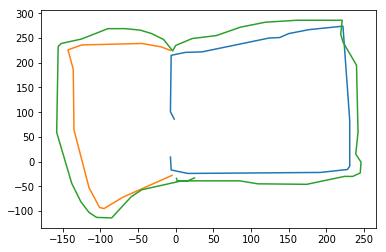

In [215]:
lines = strokes_to_lines(train[5])
plt.figure()
for line in lines:
    line = np.array(line)
    plt.plot(line[:,0],line[:,1])

### Implementation 

Ok, lets get this thing coded up!

![](figs/schematic.png)

In [216]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras import backend as K

import tensorflow_probability as tfp
tfd = tfp.distributions

In [220]:
max_seq_length = dl.max_seq_length
encoder_hidden_units = 512
decoder_hidden_units= 2048 
n_latent = 128
n_gaussians= 20



tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!

if not(tf.get_default_session() is None):
    tf.get_default_session().close()

sess = tf.InteractiveSession()

### ENCODER

encoder_inputs = tf.placeholder(tf.float32,shape=(None,None,5),name='inputs')

def pad_input_length(args,max_seq_length):
    to_pad = max_seq_length-tf.shape(args)[-2]
    tf.Assert(to_pad >= 0, [to_pad])
    padding = tf.tile([[[0.0,0.0,0.0,0.0,1.0]]],[tf.shape(args)[0],to_pad,1])
    return tf.concat([args,padding],axis=-2)
encoder_inputs = Lambda(pad_input_length,arguments={'max_seq_length' : max_seq_length})(encoder_inputs)

encoder_net = Sequential()
encoder_net.add(Bidirectional(LSTM(encoder_hidden_units,return_sequences=False),name='encoder_LSTMs'))
encoder_net.add(BatchNormalization()) # They use layer norm, but you know, laziness
encoder_net.add(Dense(2*n_latent,name='means_log_stds'))
encoder_net.add(BatchNormalization())

latent_in = encoder_net(encoder_inputs)

def _softplus_inverse(x):
  """Helper which computes the function inverse of `tf.nn.softplus`."""
  return tf.log(tf.expm1(x))

def get_dist_from_latent(latent_in):
    mean,softp_inv = tf.split(latent_in,num_or_size_splits=2,axis=-1)
    return tfp.distributions.MultivariateNormalDiag(
        loc=mean,
        scale_diag=tf.nn.softplus(softp_inv+_softplus_inverse(1.0)),name='encoder_dist')

prior_dist = tfp.distributions.MultivariateNormalDiag(
        loc=tf.zeros(n_latent),
        scale_identity_multiplier=1.0,name='encoder_dist_prior')

encoder_dist = get_dist_from_latent(latent_in)
z = encoder_dist.sample()

##### DECODER

h0 = Dense(decoder_hidden_units,activation='tanh',name='h0')(z)
h0 = BatchNormalization()(h0)
c0 = Dense(decoder_hidden_units,activation='tanh',name='c0')(z)
c0 = BatchNormalization()(c0)

decoderLSTM = LSTM(decoder_hidden_units,return_sequences=True,name='decoderLSTM') # Define so that can share weights with predict later

def concat_repeated_z(args):
    z,inputs = args
    tiled_z = K.tile(K.expand_dims(z,axis=1),[1,K.shape(inputs)[1],1])
    return Concatenate()([tiled_z,inputs])
training_decoder_in = Lambda(concat_repeated_z,name='concat_inputs_latents')([z,encoder_inputs]) # Pad each entry with z
training_decoder_output = decoderLSTM(training_decoder_in,initial_state = (h0,c0))
training_decoder_output = BatchNormalization()(training_decoder_output)

# Gaussian mixture model for output

def Gaussian2D(args):
    scale_tril = tfd.fill_triangular(tf.concat([tf.nn.softplus(args[...,0]+_softplus_inverse(1.0)),args[...,1],tf.nn.softplus(args[...,2]+_softplus_inverse(1.0))],axis=-1))
    return tfd.MultivariateNormalTriL(loc=args[...,3:5],scale_tril=scale_tril)

def GaussianMixtures2D(gmm_vars):
    if len(gmm_vars.shape) == 2:
        gmm_vars = tf.reshape(gmm_vars,[tf.shape(gmm_vars)[0],-1,6]) # Assumes that input will be [None,n*6]
    elif len(gmm_vars.shape) == 3:
        gmm_vars = tf.reshape(gmm_vars,[tf.shape(gmm_vars)[0],tf.shape(gmm_vars)[1],-1,6]) # Assumes that input will be [None,n*6]
    else:
        raise('Sorry input shape not supported')
    weights = gmm_vars[...,0]
    scale_trils = tfd.fill_triangular(
        tf.concat([tf.nn.softplus(tf.expand_dims(gmm_vars[...,1],axis=-1)+_softplus_inverse(1.0)),
                     tf.expand_dims(gmm_vars[...,2],axis=-1),
                     tf.nn.softplus(tf.expand_dims(gmm_vars[...,3],axis=-1)+_softplus_inverse(1.0))],axis=-1))
    means = gmm_vars[...,4:6]
    return tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits = weights),
        components_distribution=tfd.MultivariateNormalTriL(loc=means,scale_tril=scale_trils),name='gmm')

    
dense_pos = TimeDistributed(Dense(n_gaussians*6))(training_decoder_output)
dense_pos = BatchNormalization()(dense_pos)
encoder_pos_dists = GaussianMixtures2D(dense_pos)
encoder_pos_out = encoder_pos_dists.sample()

dense_q = TimeDistributed(Dense(3))(training_decoder_output)
dense_q = BatchNormalization()(dense_q)

encoder_q_soft = TimeDistributed(Softmax())(dense_q)
encoder_q_out = tf.one_hot(tf.argmax(dense_q,axis=-1),depth=3)

out_strokes = Concatenate()([encoder_pos_out,encoder_q_out])

encoder_log_probs_pos = encoder_pos_dists.log_prob(encoder_inputs[...,:2])
loss_pos = -tf.reduce_mean(tf.reduce_sum(encoder_log_probs_pos,axis=-1))/max_seq_length

input_inds = tf.argmax(encoder_inputs[...,2:],axis=-1)
loss_q = tf.reduce_mean(tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=input_inds,
    logits=dense_q),axis=-1))/max_seq_length

loss_KL = tf.reduce_mean(tfd.kl_divergence(prior_dist,encoder_dist))
w_kl = 1.0
total_loss = (loss_pos+loss_q + w_kl * loss_KL)

train = tf.train.AdamOptimizer().minimize(total_loss)

tf.global_variables_initializer().run() 

In [ ]:
for i in range(dl.num_batches):
    _,batch,_ = dl.get_batch(i)
    _,losses_pos,losses_q,losses_KL = sess.run([train,loss_pos,loss_q,loss_KL],feed_dict = {encoder_inputs : batch})
    print(i,losses_pos,losses_q,losses_KL)

In [53]:
pred = out_strokes.eval(feed_dict = {encoder_inputs : [batch[4]]})[0]


In [60]:
to_normal_strokes(batch[4])

array([[   0.,    0.,    0.],
       [   7.,   58.,    0.],
       [   2.,   62.,    0.],
       [   0.,   34.,    0.],
       [  -6.,   45.,    0.],
       [  26.,  -17.,    0.],
       [  85.,  -31.,    0.],
       [  26.,    0.,    0.],
       [  25.,    6.,    0.],
       [  19.,    9.,    0.],
       [  -6.,  -89.,    0.],
       [ -11.,  -76.,    0.],
       [ -16.,  -24.,    0.],
       [ -18.,   -7.,    0.],
       [ -21.,   -3.,    0.],
       [-119.,    2.,    0.],
       [  -1.,   -5.,    0.],
       [   0.,   23.,    0.],
       [  18.,   43.,    1.],
       [ 177.,  -57.,    0.],
       [  46.,   -7.,    0.],
       [  26.,  -12.,    0.],
       [  26.,  -19.,    0.],
       [  31.,  -10.,    0.],
       [  33.,   -3.,    0.],
       [   1.,    7.,    0.],
       [   4.,  251.,    0.],
       [ -46.,  -18.,    0.],
       [ -67.,   -3.,    0.],
       [ -22.,    4.,    0.],
       [ -10.,   -4.,    1.],
       [   0.,    0.,    0.],
       [  -3.,  -42.,    0.],
       [ -

In [64]:
strokes_to_lines(to_normal_strokes(pred))

[]

In [56]:
lines = strokes_to_lines(to_normal_strokes(pred))
plt.figure()
for line in lines:
    line = np.array(line)
    plt.plot(line[:,0],line[:,1])
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

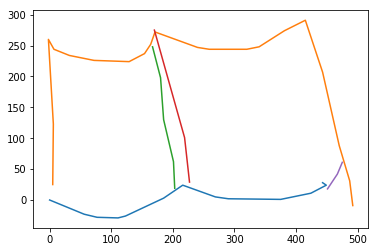

In [28]:
lines = strokes_to_lines(to_normal_strokes(batch[20]))
plt.figure()
for line in lines:
    line = np.array(line)
    plt.plot(line[:,0],line[:,1])
plt.show()